In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import torch.utils.data as td
import json
import math
import matplotlib.pyplot as plt
import onnx
import onnx.numpy_helper
import torchvision.transforms as xf
import random
import re
import gzip

In [2]:
%matplotlib notebook

In [3]:
class DrivingDataset(td.Dataset):

    def __init__(self, file, transform=None, aux=0., name=None, window = 5):
        if re.match(r'^.*\.gz$', file):
            with gzip.open(file) as f:
                X = json.load(f)
        else:
            with open(file) as f:
                X = json.load(f)
        self.names = X[0]
        X=X[1:]
        self.numframes = len(X)
        self.elapsed = (X[-4][self.names["time"]] - X[0][self.names["time"]]) / 1000
        self.resolution = round(math.sqrt(len(X[0][self.names['img']])/4))
        self.expert_acts = torch.tensor([[x[self.names["expert_x"]], x[self.names["expert_y"]]] for x in X])
        self.actual_acts = torch.tensor([[x[self.names["applied_x"]], x[self.names["applied_y"]]] for x in X])
        self.did_reset = torch.tensor([1 if x[self.names['reset']] else 0 for x in X])
        self.frames = torch.tensor([x[self.names['img']] for x in X]).reshape([-1, self.resolution, self.resolution, 4])[:,:,:,0:3]
        self.framesgy = self.frames.sum(-1)/(255*3)
        self.transform = transform
        self.aux = torch.tensor([aux])
        self.name = name
        self.window = window

    def __str__(self):
        res = []
        if self.name:
            res.extend([self.name, ": "])
        res.append(f"{len(self)} frame groups in {self.elapsed} s, {(self.numframes-1)/self.elapsed:.6} fps avg")
        return ''.join(res)

    def __len__(self):
        return self.numframes - self.window + 1

    def __getitem__(self, idx):
        imgs = self.framesgy[idx:idx+self.window,:,:]
        exp_act = self.expert_acts[idx+self.window-1,:]
        act_act = self.actual_acts[idx:idx+self.window-1,:]
        act_noise = self.actual_acts[idx+self.window-1,:] - self.expert_acts[idx+self.window-1,:]
        if self.transform:
            (imgs, exp_act, act_act) = self.transform(imgs, exp_act, act_act)
        return imgs, act_act, exp_act, act_noise, self.aux

def show_sa(img, act, act2=None, colorbar=False):
    res = img.shape[-1]
    midpt = (1+res)*0.5
    scale = res/32
    plt.imshow(1-img, 'Greys', vmin=0, vmax=1)
    plt.plot([midpt, midpt+scale*act[0]], [midpt, midpt-scale*act[1]], 'r')
    if act2 is not None:
        plt.plot([midpt, midpt+scale*act2[0]], [midpt, midpt-scale*act2[1]], 'g')
    if colorbar:
        plt.colorbar()
    
# class DiscrimDataset(td.Dataset):

#     def __init__(self, pos, neg):
#         self.items = torch.concat((pos, neg))
#         self.npos = pos.shape[0]
#         self.nneg = neg.shape[0]
#         self.n = self.npos + self.nneg
#         self.labels = torch.concat((torch.ones((self.npos, 1)), -torch.ones((self.nneg, 1))))

#     def __len__(self):
#         return self.n

#     def __getitem__(self, idx):
#         return self.items[idx, :], self.labels[idx]

In [4]:
# An architecture similar to LeNet, except that the list of previous actions comes in at the first fully-connected layer

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(5, 6, 5, padding=2)
        self.pool1 = nn.AvgPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.AvgPool2d(2, stride=2)
        self.fc1 = nn.Linear(576+8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
    
    def load_onnx(self, model):
        wts = { t.name: torch.tensor(onnx.numpy_helper.to_array(t)) for t in model.graph.initializer }
        self.load_state_dict(wts)

    def forward(self, x0, x1, x2, x3, x4, a0, a1, a2, a3):
        acts = torch.cat((a0, a1, a2, a3), dim=1)
        z = torch.stack((x0, x1, x2, x3, x4), dim=1)
        z = F.relu(self.conv1(z))
        z = self.pool1(z)
        z = F.relu(self.conv2(z))
        z = self.pool2(z)
        # print(z.shape)
        z = F.relu(self.fc1(torch.cat((torch.flatten(z, 1), acts), dim=1)))
        z = F.relu(self.fc2(z))
        return self.fc3(z), z

    def forward_stacked(self, img, act):
        return self.forward(img[:,0,:,:], img[:,1,:,:], img[:,2,:,:], img[:,3,:,:], img[:,4,:,:], act[:,0,:], act[:,1,:], act[:,2,:], act[:,3,:])

net = Net()
loss = F.mse_loss
sgd = opt.SGD(net.parameters(), lr=0.001)

In [8]:
td4noxform = DrivingDataset('data/assist-dagger-2.json')
selfdrive = DrivingDataset('data/self-drive-3.json')
random = DrivingDataset('data/random.json.gz')
# discrim_data = td.DataLoader(td.ConcatDataset([td4noxform, selfdrive]), batch_size = 64)

In [6]:
# would be worth displaying time index as we label
# might be nice to pass in a starting dict of labels

class ImageLabeler:
    def __init__(self, dataset, ax, label_list = {'0', '1', '2'}):
        self.dataset = dataset
        self.ax = ax
        self.t = 0
        self.im = None
        self.labels = {}
        self.label_list = label_list
        lines = ax.plot(0, 0, 'b')
        self.line = lines[0]
        self.txt = ax.text(2, 2, '.', color='r')
        self.show(self.t)
        ax.figure.canvas.mpl_connect('key_press_event', self)
        
    def show(self, t):
        (img, act, exp, nse, aux) = self.dataset[t]
        res = img.shape[-1]
        midpt = (1+res)*0.5
        scale = res/32
        if self.im is not None:
            self.im.set_data(1-img[0,:,:])
        else:
            self.im = self.ax.imshow(1-img[0,:,:], 'Greys', vmin=0, vmax=1)
        self.line.set_xdata([midpt, midpt+scale*act[0,0]])
        self.line.set_ydata([midpt, midpt-scale*act[0,1]])
        if self.t in self.labels:
            self.txt.set_text(self.labels[t])
        else:
            self.txt.set_text('.')

    def __call__(self, ev):
        if (ev.key == 'z'):
            self.t -= 30
        elif (ev.key == 'x'):
            self.t -= 1
        if (ev.key == 'c'):
            self.t += 1
        elif (ev.key == 'v'):
            self.t += 30
        if self.t >= len(self.dataset):
            self.t -= len(self.dataset)
        if self.t < 0:
            self.t += len(self.dataset)
        if ev.key in self.label_list:
            self.labels[self.t] = ev.key
        if ev.key == '.':
            del self.labels[self.t]
        self.show(self.t)


<IPython.core.display.Javascript object>


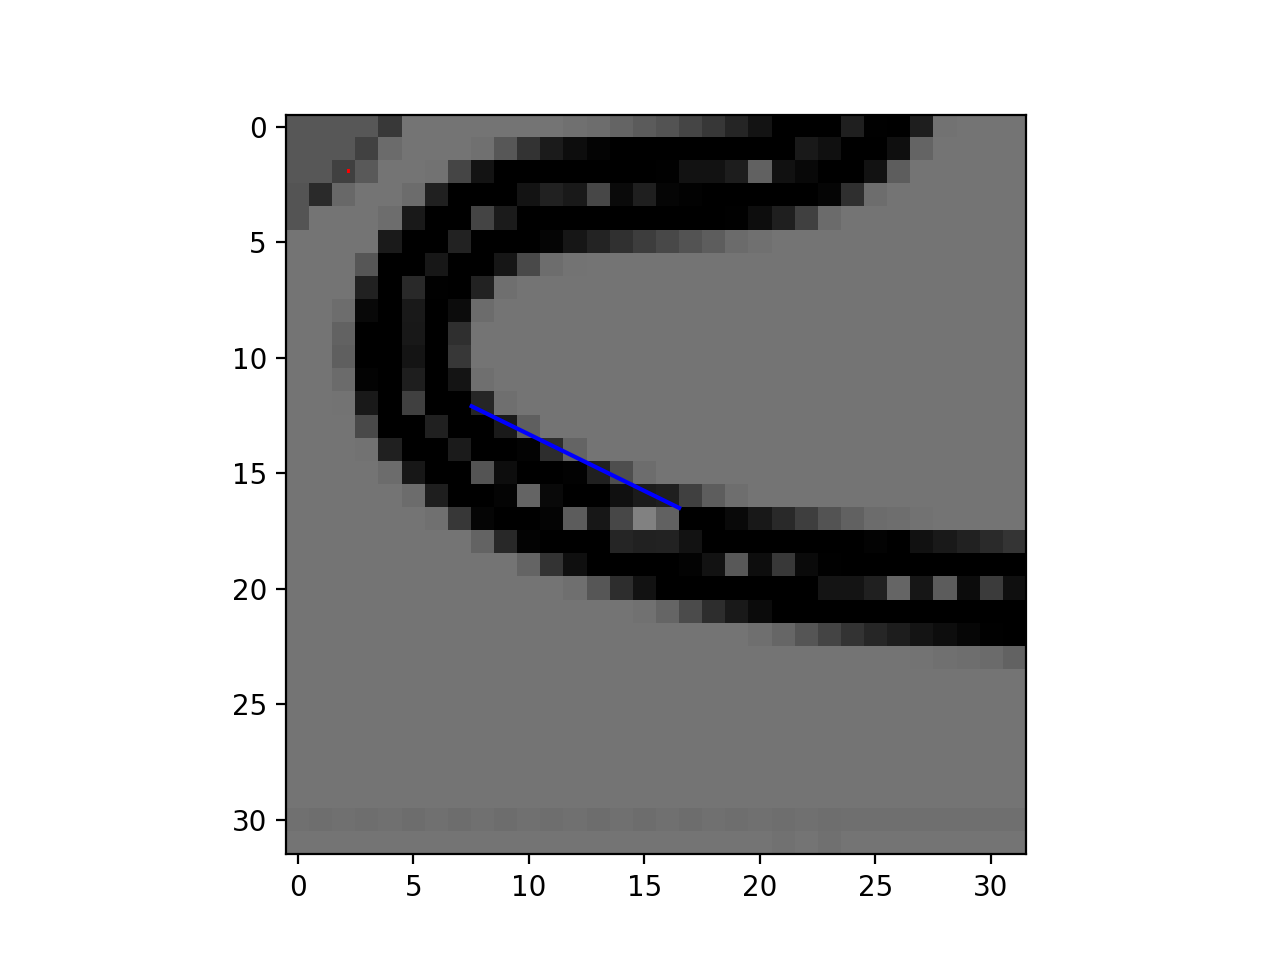

In [7]:
fig, ax = plt.subplots()
lblself = ImageLabeler(selfdrive, ax)

<IPython.core.display.Javascript object>


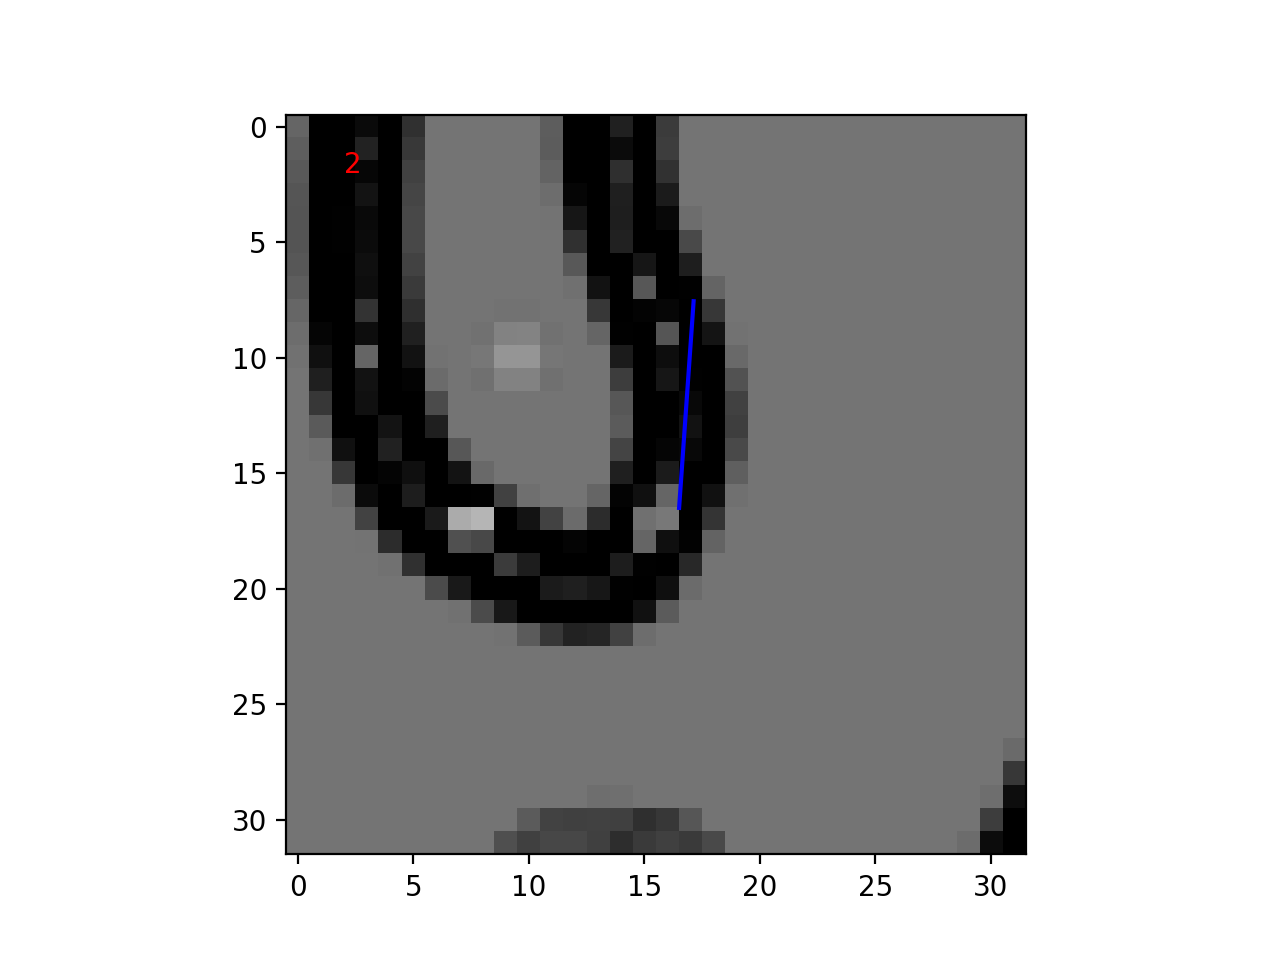

In [85]:
fig, ax = plt.subplots()
lblexp = ImageLabeler(td4noxform, ax)

<IPython.core.display.Javascript object>


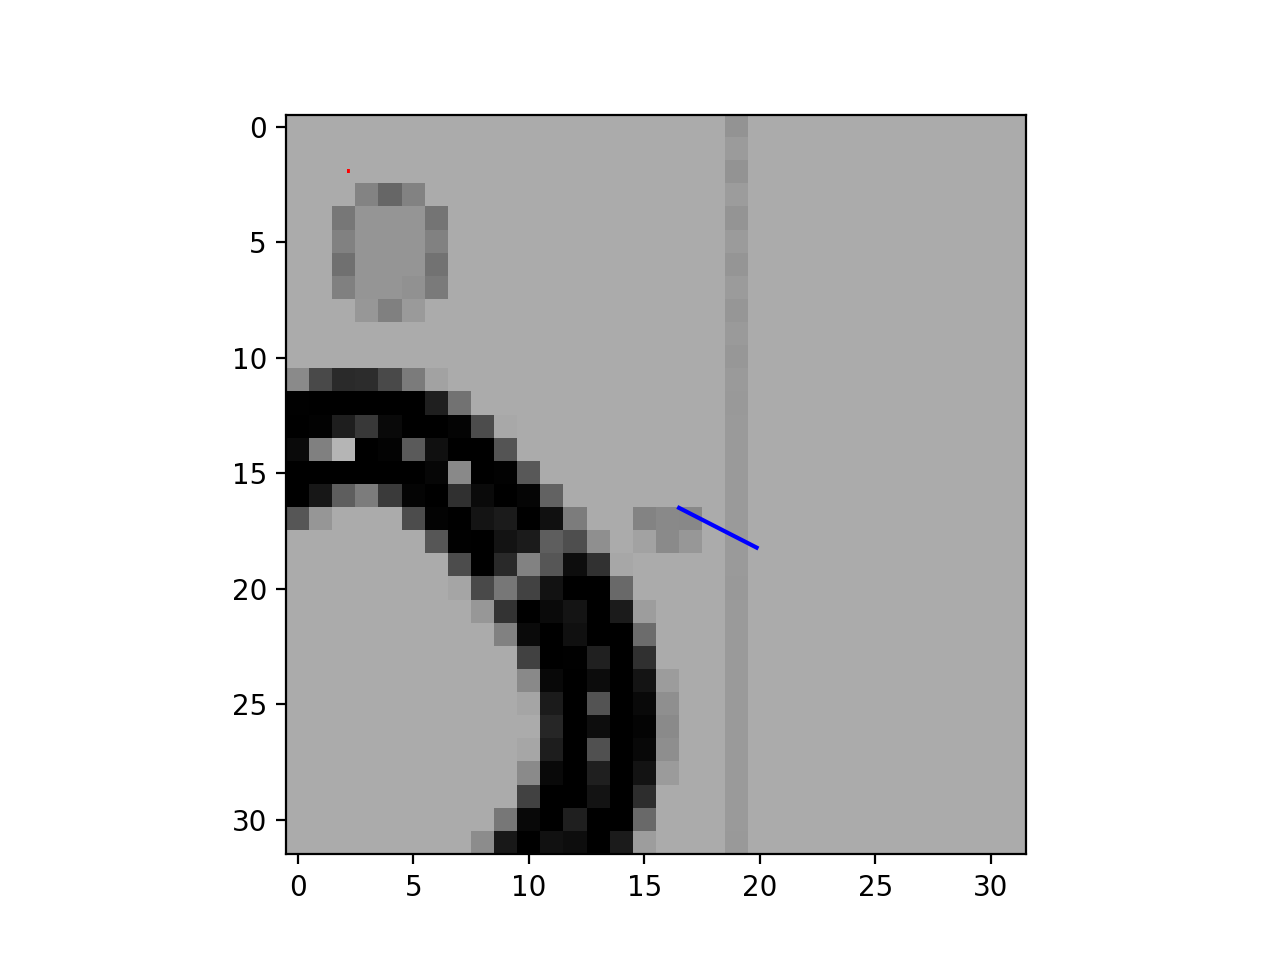

In [9]:
fig, ax = plt.subplots()
lblrand = ImageLabeler(random, ax)

In [49]:
# for animation, use FuncAnimation

In [84]:
lblself.labels

{65: '1',
 66: '1',
 67: '1',
 68: '1',
 69: '1',
 70: '1',
 71: '1',
 72: '1',
 73: '1',
 74: '1',
 75: '1',
 76: '1',
 77: '1',
 78: '1'}

In [86]:
lblexp.labels

{270: '2',
 271: '2',
 272: '2',
 273: '2',
 274: '2',
 275: '2',
 276: '2',
 277: '2',
 278: '2',
 279: '2',
 280: '2',
 281: '2',
 282: '2',
 283: '2',
 284: '2',
 285: '2',
 286: '2',
 287: '2',
 288: '2',
 289: '2',
 290: '2',
 291: '2',
 292: '2',
 293: '2',
 294: '2',
 295: '2',
 296: '2',
 297: '2',
 298: '2',
 299: '2',
 300: '2',
 301: '2'}

In [11]:
lblrand.labels

{0: '1',
 1: '1',
 2: '1',
 3: '1',
 4: '1',
 5: '1',
 6: '1',
 7: '1',
 8: '1',
 9: '1',
 10: '1',
 11: '1',
 12: '1',
 13: '1',
 14: '1',
 15: '1',
 16: '2',
 17: '2',
 18: '2',
 19: '2',
 20: '2',
 21: '1',
 22: '1',
 23: '2',
 24: '1',
 25: '1',
 26: '1',
 27: '2',
 28: '1',
 29: '1',
 30: '1',
 31: '1',
 32: '1',
 33: '1',
 63: '1',
 64: '1',
 65: '1',
 66: '1',
 67: '1',
 68: '1',
 69: '1',
 70: '1',
 71: '1',
 72: '1',
 73: '1',
 74: '1',
 75: '1',
 76: '1',
 77: '1',
 78: '1',
 79: '1',
 80: '1',
 81: '1',
 82: '1',
 83: '1',
 84: '1',
 85: '1',
 144: '1',
 145: '1',
 146: '1',
 147: '1',
 148: '1',
 149: '1',
 150: '1',
 151: '1',
 152: '1',
 153: '1',
 154: '1',
 155: '1',
 156: '1',
 157: '1',
 158: '1',
 159: '1',
 160: '1',
 161: '1',
 162: '1',
 163: '1',
 164: '1',
 165: '1',
 166: '1',
 167: '1',
 168: '1',
 169: '1',
 170: '1',
 171: '1',
 172: '1',
 173: '1',
 174: '1',
 175: '1',
 176: '1',
 177: '1',
 178: '1',
 179: '1',
 180: '1',
 181: '1',
 182: '1',
 183: '1',


In [12]:
len(lblrand.labels)

568